# NLP: User experience multilabel classification

**Задача**

Целью проекта является разработка модели машинного обучения для классификации отзывов клиентов,<br> которые могут одновременно принадлежать к нескольким категориям из предложенного набора.



**Метрика**


Эффективность модели оценивается с помощью Accuracy, определяемой как доля полных совпадений списка выбранных категорий с эталонным списком по всем экземплярам данных.

**План проекта**









1.  Загрузка данных
2.  Предварительный обзор данных
4. Первичная валидация
4.  EDA
6. Валидация моделей и методов представления текстов
7. Выбор моделей и получение предсказаний для тестового набора

## Загрузка данных

In [ ]:
!pip install pymorphy2 emoji transformers catboost nlpaug wordcloud stop-words -q


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import unicodedata
import pymorphy2
import pathlib
import random
import emoji
import torch
import copy
import nltk
import json
import sys
import re

import nlpaug.model.lang_models as nml
import nlpaug.augmenter.word as naw

from transformers.trainer_callback import EarlyStoppingCallback
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    EvalPrediction,
    AutoTokenizer,
    AutoConfig,
    AutoModel,
    pipeline,
    Trainer
)


from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline


from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_predict,
    KFold,
    cross_val_score
)

from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    accuracy_score,
    classification_report,
)

from torch.utils.data import DataLoader, TensorDataset
from catboost import CatBoostClassifier, Pool
from torch.utils.data.dataset import Dataset
from xgboost import XGBClassifier
from collections import Counter
from wordcloud import WordCloud
from tqdm.auto import tqdm


2024-03-14 09:35:48.534072: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 09:35:48.534174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 09:35:48.716866: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
morph = pymorphy2.MorphAnalyzer()
nltk.download('punkt')
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian');

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('/kaggle/input/samokat/train.csv')
test_df = pd.read_csv('/kaggle/input/samokat/test.csv')
description = pd.read_csv('/kaggle/input/samokat/trends_description.csv')

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)



---



In [ ]:
df.head()

,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,trend_id_res9,trend_id_res10,trend_id_res11,trend_id_res12,trend_id_res13,trend_id_res14,trend_id_res15,trend_id_res16,trend_id_res17,trend_id_res18,trend_id_res19,trend_id_res20,trend_id_res21,trend_id_res22,trend_id_res23,trend_id_res24,trend_id_res25,trend_id_res26,trend_id_res27,trend_id_res28,trend_id_res29,trend_id_res30,trend_id_res31,trend_id_res32,trend_id_res33,trend_id_res34,trend_id_res35,trend_id_res36,trend_id_res37,trend_id_res38,trend_id_res39,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,15237,5.0,"{ASSORTMENT,PRODUCTS_QUALITY,PROMOTIONS,CATALOG_NAVIGATION}",Доставка просто 👍,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(8708, 54)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 54 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           8708 non-null   int64  
 1   assessment      8478 non-null   float64
 2   tags            8697 non-null   object 
 3   text            8708 non-null   object 
 4   trend_id_res0   8708 non-null   int64  
 5   trend_id_res1   8708 non-null   int64  
 6   trend_id_res2   8708 non-null   int64  
 7   trend_id_res3   8708 non-null   int64  
 8   trend_id_res4   8708 non-null   int64  
 9   trend_id_res5   8708 non-null   int64  
 10  trend_id_res6   8708 non-null   int64  
 11  trend_id_res7   8708 non-null   int64  
 12  trend_id_res8   8708 non-null   int64  
 13  trend_id_res9   8708 non-null   int64  
 14  trend_id_res10  8708 non-null   int64  
 15  trend_id_res11  8708 non-null   int64  
 16  trend_id_res12  8708 non-null   int64  
 17  trend_id_res13  8708 non-null   i

---

## Первичная валидация

In [ ]:
#Список целевых столбцов
target_cols = [f'trend_id_res{i}' for i in range(50)]
#Список названий классов
target_names = list(description['trend'])
#Количество отзывов каждого класса
trend_counts = df[target_cols].sum(axis=0)

Определим метод представления текста и модель для первичной валидации

In [ ]:
tfidf = TfidfVectorizer(
    analyzer = 'char_wb',
    max_features=1000,
    ngram_range=(1,3))

In [ ]:
lr = MultiOutputClassifier(LogisticRegression(max_iter=10000), n_jobs=-1)

In [ ]:
def get_pipe(*, method=tfidf, model=lr, text_col='text'):
    """
    Создает и возвращает конвейер для предобработки текста и обучения модели.

    Параметры:
    - method: метод векторизации текста (по умолчанию TfidfVectorizer).
    - model: модель машинного обучения (по умолчанию LogisticRegression).
    - text_col: название столбца с текстом в данных (по умолчанию 'text').

    Возвращаемое значение:
    - pipe: конвейер, готовый к использованию для обучения модели.
    """
    preprocessor = ColumnTransformer(
        [("vectorizer", method, text_col)],
        remainder="passthrough"
    )

    pipe = Pipeline(
        [
            ('preprocessor', preprocessor),
            ('clf', model)
        ]
    )

    return pipe

In [ ]:
lr_pipe = get_pipe()

In [ ]:
def cv(df, n_splits=3, *, pipeline, reports_df=False, features2drop=['index', 'assessment', 'tags']):
    """
    Функция для выполнения кросс-валидации модели на данных.

    Параметры:
    - df: DataFrame, содержащий данные для обучения и тестирования.
    - n_splits: количество разбиений для кросс-валидации.
    - pipeline: конвейер предобработки данных и модели машинного обучения.
    - reports_df: логический флаг для возврата DataFrame с отчетами по каждому разбиению.
    - features2drop: список названий столбцов для исключения из данных перед обучением.

    Возвращает:
    - Если reports_df=True, возвращает DataFrame с метриками модели для каждого таргета и среднюю точность.
    - В противном случае выводит только среднюю точность модели.
    """

    # Определение входных и выходных данных
   # tartget_cols = [f'trend_id_res{i}' for i in range(50)]
    filtered_cols = [col for col in df.columns if col not in target_cols + features2drop]
    X = df[filtered_cols]
    y = df[target_cols]


    # Настройка кросс-валидации
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    overall_accuracy = []
    reports = []


    for train_index, test_index in tqdm(kf.split(X), total=n_splits, desc="KFold Progress"):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]


        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True, zero_division=0)

        reports.append(report)
        overall_accuracy.append(accuracy_score(y_test, y_pred))



    if reports_df == True:
      # Сбор и обработка результатов
        avg_scores = {name: {'precision': [], 'recall': [], 'f1-score': []} for name in target_names}

        for report in reports:
            for name in target_names:
                if name in report:
                    for metric in ['precision', 'recall', 'f1-score']:
                        avg_scores[name][metric].append(report[name][metric])

        for name in avg_scores:
            avg_scores[name] = {metric: np.mean(values) for metric, values in avg_scores[name].items()}

        scores_df = pd.DataFrame(avg_scores).T
        scores_df.insert(0, 'Review Count', trend_counts.tolist())
        scores_df.loc['Overall Accuracy', :] =  [0, 0, 0,np.mean(overall_accuracy)]
        scores_df['Review Count'] = scores_df['Review Count'].astype('int')

        return scores_df
    else:
        print('Accuracy:')
        return np.mean(overall_accuracy).round(3)

In [ ]:
cv(df, pipeline=lr_pipe, reports_df=True)

KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

,Review Count,precision,recall,f1-score
Долгая доставка,837,0.797856,0.361674,0.497013
Доставка стала долгой,347,0.639444,0.100424,0.173085
Время доставки не соответствует заявленому,597,0.645285,0.252067,0.360765
Регулярные опоздания,361,0.670466,0.195820,0.302182
Не отследить реальное время доставки,126,0.000000,0.000000,0.000000
Курьер на карте,52,0.000000,0.000000,0.000000
Нет доставки по адресу,21,0.000000,0.000000,0.000000
Не предупреждаем об удалении товара,35,0.000000,0.000000,0.000000
Высокая минимальная сумма заказа,140,0.250000,0.028571,0.051282
Сумма заказа меняется во время набора корзины,10,0.000000,0.000000,0.000000




---



## EDA

### Предобработка

In [ ]:
df.drop(target_cols, axis=1).isna().sum()

index           0
assessment    230
tags           11
text            0
dtype: int64

In [ ]:
test_df.isna().sum()

index           0
assessment    466
tags           32
text            2
dtype: int64

#### Assessment

In [ ]:
df[df['assessment'].isna()].sample(10)

,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,trend_id_res9,trend_id_res10,trend_id_res11,trend_id_res12,trend_id_res13,trend_id_res14,trend_id_res15,trend_id_res16,trend_id_res17,trend_id_res18,trend_id_res19,trend_id_res20,trend_id_res21,trend_id_res22,trend_id_res23,trend_id_res24,trend_id_res25,trend_id_res26,trend_id_res27,trend_id_res28,trend_id_res29,trend_id_res30,trend_id_res31,trend_id_res32,trend_id_res33,trend_id_res34,trend_id_res35,trend_id_res36,trend_id_res37,trend_id_res38,trend_id_res39,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
5324,3007,NaN,"{ASSORTMENT,PROMOTIONS}",Всё супер! Спасибо!,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8484,10658,NaN,"{ASSORTMENT,PRICE,PROMOTIONS}",👍🏻👍🏻👍🏻,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6770,15654,NaN,"{PRODUCTS_QUALITY,PROMOTIONS,PAYMENT,DELIVERY}",Палочка-выручалочка,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
730,17772,NaN,"{ASSORTMENT,PROMOTIONS,PRICE}",💝🫂,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
763,19030,NaN,{DELIVERY},"Доставка слишком долгая, [NUM] минут. Обычно всегда привозят даже больше [NUM] минут. Откройте пункт поближе",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8521,14714,NaN,"{PRODUCTS_QUALITY,PROMOTIONS,DELIVERY,PAYMENT}",Обожаю вас за быструю доставку и бывают хорошие акции,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2551,18497,NaN,"{PRICE,PRODUCTS_QUALITY,PAYMENT,PROMOTIONS}",Отлично,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8077,11848,NaN,"{ASSORTMENT,PRICE,PROMOTIONS}","Хорошее приложение, частые скидки, спасибо",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6317,11236,NaN,"{ASSORTMENT,PRICE,PROMOTIONS,DELIVERY}","Красавцы , круто двигаетесь!",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5352,7458,NaN,"{ASSORTMENT,PROMOTIONS}",👍🏼,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Функция получения числа классов, к которым относится отзыв
def get_tag_count(df):
    df['tag_count'] = df[target_cols].sum(axis=1)
    return df

In [ ]:
df = get_tag_count(df)

In [ ]:
df['tag_count'].value_counts()

tag_count
0    4085
1    3012
2    1173
3     354
4      84
Name: count, dtype: int64

In [ ]:
color = '#0ABAB5'

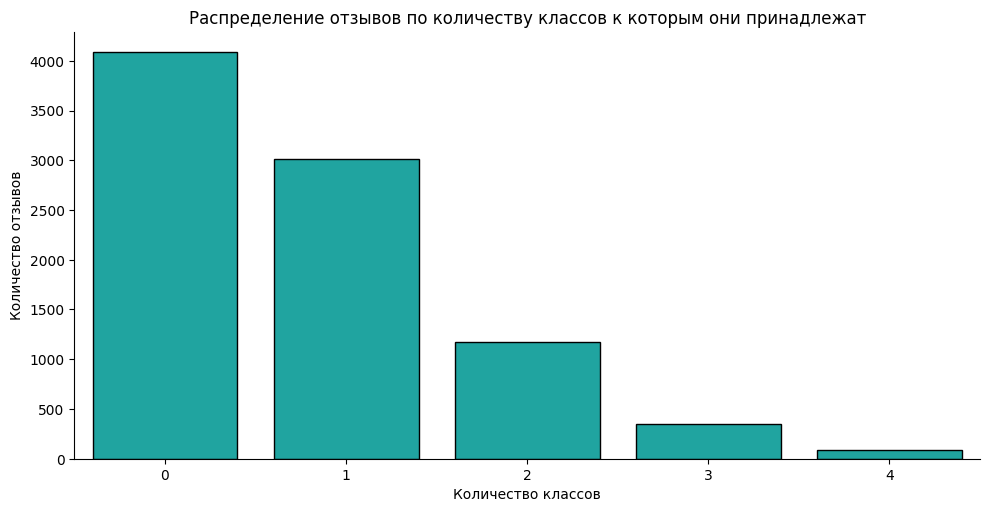

In [ ]:
g = sns.catplot(
      data=df,
      x="tag_count",
      aspect=2,
      kind='count',
      color=color,
      edgecolor='black'
  )
plt.xlabel('Количество классов')
plt.ylabel('Количество отзывов')
plt.title('Распределение отзывов по количеству классов к которым они принадлежат');

**В нашем датафрейме 47% всех отзывов неразмечены(не относятся ни к одному классу).**

In [ ]:
df.query('tag_count == 0').sample(10)

,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,trend_id_res9,trend_id_res10,trend_id_res11,trend_id_res12,trend_id_res13,trend_id_res14,trend_id_res15,trend_id_res16,trend_id_res17,trend_id_res18,trend_id_res19,trend_id_res20,trend_id_res21,trend_id_res22,trend_id_res23,trend_id_res24,trend_id_res25,trend_id_res26,trend_id_res27,trend_id_res28,trend_id_res29,trend_id_res30,trend_id_res31,trend_id_res32,trend_id_res33,trend_id_res34,trend_id_res35,trend_id_res36,trend_id_res37,trend_id_res38,trend_id_res39,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49,tag_count
639,961,NaN,"{PAYMENT,PRICE,ASSORTMENT,PROMOTIONS}","хорошая доставка продуктов, но было бы удобнее, если бы можно было оплачиваьь покупки курьеру, а не онлайн",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
789,11813,5.0,{DELIVERY},Быстрая доставка,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5460,15802,5.0,"{ASSORTMENT,PRODUCTS_QUALITY,PAYMENT,DELIVERY,PROMOTIONS}","Хотелось бы добавить, что если позиции в заказе нет, то предлагают заменить чем-то, или предупреждать, а не в тихую удалять просто из заказа, а пои получении видеть «сюрприз»",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8520,7857,5.0,"{ASSORTMENT,PRODUCTS_QUALITY,PRICE,PROMOTIONS,CATALOG_NAVIGATION,PAYMENT,SUPPORT}",все гуд,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6628,13779,5.0,{DELIVERY},"Очень круто, но долго",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2220,7577,5.0,"{PRICE,PROMOTIONS}","Очень быстрая доставка, даже если задержались. вежливые курьеры.",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8261,20197,5.0,"{PRICE,PROMOTIONS,PAYMENT,SUPPORT}",Пока набирала исчезли бонусы,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3246,15062,5.0,"{DELIVERY,PRICE}","Скачут цены на одни и те же продукты, словно цены взяли с потолка, при том в магазине, даже не близко, а тут с жуткой наценкой, да еще и типа по скидке. Плюс не нравится точность времени доставки, пишет [NUM] минуты, которые идут [NUM] минут :)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7277,10232,5.0,"{PROMOTIONS,DELIVERY,ASSORTMENT}",бывает хорошо а бывает очень плохо,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4449,5029,5.0,"{ASSORTMENT,DELIVERY,PAYMENT,PROMOTIONS}","В целом,очень удобно,но иногда доставка ооочень долгая.И минимальную сумму заказа можно было-бы сделать немного меньше.И да,давать немного больше бонусов,чем щас.И расширить зону доставки.А так,всё классно и очень удобно",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.query('tag_count == 0')['assessment'].value_counts()

assessment
5.0    3824
6.0      13
3.0       8
2.0       4
4.0       3
0.0       2
1.0       1
Name: count, dtype: int64

In [ ]:
df.query('assessment == 5')['tag_count'].value_counts()

tag_count
0    3824
Name: count, dtype: int64

In [ ]:
df[df['assessment'].isna()]['tag_count'].value_counts()

tag_count
0    230
Name: count, dtype: int64

In [ ]:
df[df['text'].duplicated()]\
    .sort_values(by='text')\
    [['text', 'assessment', 'tag_count']]\
    .iloc[510:540]

,text,assessment,tag_count
1929,Долго,0.0,1
7509,Долго,3.0,1
4627,Долго,NaN,0
1902,Долго,3.0,1
7986,Долго,0.0,1
5702,Долго,0.0,1
7816,Долго,4.0,1
694,Долго,1.0,1
3845,Долго,0.0,1
654,Долго,2.0,1


In [ ]:
df['assessment'] = df['assessment'].fillna(5).astype('int')

- 99.2%  неразмеченных строк имеют оценку 5
- 100% строк с оценкой 5 или пропуском оценки неразмечены
- В тестовом наборе также имеются пропуски оценки(466), а 47% строк неразмечены(определено путем отправки таблицы с ответами заполненной нулями).

Исходя из этого, лучшим решением - будет заполнить пропуски в столбце `assessment` 5.

In [ ]:
cv(df, features2drop=['index', 'tags', 'tag_count'], pipeline=lr_pipe)

KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


0.523

In [ ]:
df['unlabeled'] = np.where(df['assessment'] == 5, 1, 0)

In [ ]:
cv(df, features2drop=['index', 'tags', 'tag_count'], pipeline=lr_pipe)

KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


0.605

In [ ]:
cv(df.query('unlabeled == 0'), features2drop=['index', 'tags', 'tag_count'], pipeline=lr_pipe)

KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


0.269

Благодаря признаку `unlabeled` модель улучшила результаты почти на 0.08, верно определяя большинство неразмеченных строк(а это почти половина). Для размеченных строк ее предсказательная способность оставляет желать лучшего - `Accuracy ~ 0.26



---



#### Tags

In [ ]:
df[df['tags'].isna()]

,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,trend_id_res9,trend_id_res10,trend_id_res11,trend_id_res12,trend_id_res13,trend_id_res14,trend_id_res15,trend_id_res16,trend_id_res17,trend_id_res18,trend_id_res19,trend_id_res20,trend_id_res21,trend_id_res22,trend_id_res23,trend_id_res24,trend_id_res25,trend_id_res26,trend_id_res27,trend_id_res28,trend_id_res29,trend_id_res30,trend_id_res31,trend_id_res32,trend_id_res33,trend_id_res34,trend_id_res35,trend_id_res36,trend_id_res37,trend_id_res38,trend_id_res39,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49,tag_count,unlabeled
88,27009,0,NaN,говно,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
858,27033,6,NaN,Быстрая и дешëвая доставка продуктов за минут [NUM]-[NUM],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
991,27018,0,NaN,Уберите принудительное обновление.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3099,27015,0,NaN,"Долго доставляют заказы, бывают моменты когда курьер хамит, звонишь в поддержку они на пофиг разговаривают",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
3858,27005,0,NaN,Разредился телефон даже не попытались попасть подъезд,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4002,27023,3,NaN,Ты,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4858,26996,0,NaN,"Идиоты, клоуны🤮🤮🤮🤮🤮",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5003,27035,6,NaN,"Думаю хорошо, все нравится",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6120,27026,3,NaN,"В последнее время увеличилось время доставки. Сегодня доставили за [NUM] минуту. Хотя бы писали в приложении, что доставка задерживается на столько то минут, а то совсем неинтересно вместо [NUM] минут ждать непонятно сколько времени",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
6397,27017,0,NaN,Все отлично,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


В пропусках тэгов никакой закономерности не наблюдается. <br>
Извлечем тэги из столбца и закодируем методом `get_dummies`, у строк с пропусками везде окажется 0

In [ ]:
def encode_tags(df):
    df['tags'] = df['tags'].fillna('')
    df['tags'] = df['tags'].str.replace('{', '').str.replace('}', '')
    tags_dummies = df['tags'].str.get_dummies(sep=',')
    df = pd.concat([df, tags_dummies], axis=1)
    df = df.drop('tags', axis=1)
    return df

In [ ]:
df = encode_tags(df)

In [ ]:
df.head(1)

,index,assessment,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,trend_id_res9,trend_id_res10,trend_id_res11,trend_id_res12,trend_id_res13,trend_id_res14,trend_id_res15,trend_id_res16,trend_id_res17,trend_id_res18,trend_id_res19,trend_id_res20,trend_id_res21,trend_id_res22,trend_id_res23,trend_id_res24,trend_id_res25,trend_id_res26,trend_id_res27,trend_id_res28,trend_id_res29,trend_id_res30,trend_id_res31,trend_id_res32,trend_id_res33,trend_id_res34,trend_id_res35,trend_id_res36,trend_id_res37,trend_id_res38,trend_id_res39,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49,tag_count,unlabeled,ASSORTMENT,CATALOG_NAVIGATION,DELIVERY,PAYMENT,PRICE,PRODUCTS_QUALITY,PROMOTIONS,SUPPORT
0,5652,6,"Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0


In [ ]:
cv(df, features2drop=['index', 'tag_count'], pipeline=lr_pipe)

KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


0.622

---

#### Очистка текста

In [ ]:
def clean_text(text):

    #Избавимся от ссылок в тексте
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    #Для сообщений длиной до трех слов переведем смайлики в текст
    words_without_emojis = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', ' ', text)
    if len(words_without_emojis.split()) <= 3:
        text = emoji.demojize(text, language='ru')

    #Избавимся от лишних символов
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', ' ', text)

    #Уберем лишние пробелы
    text = text.strip()

    #Приведем текст к нижнему регистру
    text = text.lower()

    return text

In [ ]:
df['text'] = df['text'].fillna('')

In [ ]:
df['cleaned_text'] = df['text'].apply(clean_text).fillna('')

In [ ]:
cv(df, features2drop=['index',  'tag_count', 'text'], pipeline=get_pipe(text_col='cleaned_text'))

KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


0.624

---

#### Лемматизация

In [ ]:
def lemmatize_text(text):

    # Токенизируем текст на слова
    words = word_tokenize(text, language='russian')
    # Применяем лемматизацию к каждому слову
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    # Соединяем лемматизированные слова обратно в строку
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [ ]:
df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)

In [ ]:
cv(df, features2drop=['index',  'tag_count', 'text', 'cleaned_text'], pipeline=get_pipe(text_col='lemmatized_text'))

KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


0.625

Очистка и лемматизация текстов принесли незначительный прирост метрики

---

### Исследование данных

#### Анализ текстовых данных

In [ ]:
def count_words(text, stopwords=True):

    words = text.split()
    if stopwords == True:
        return len(words)
    else:
        filtered_words = [word for word in words if word not in russian_stopwords]
        return len(filtered_words)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


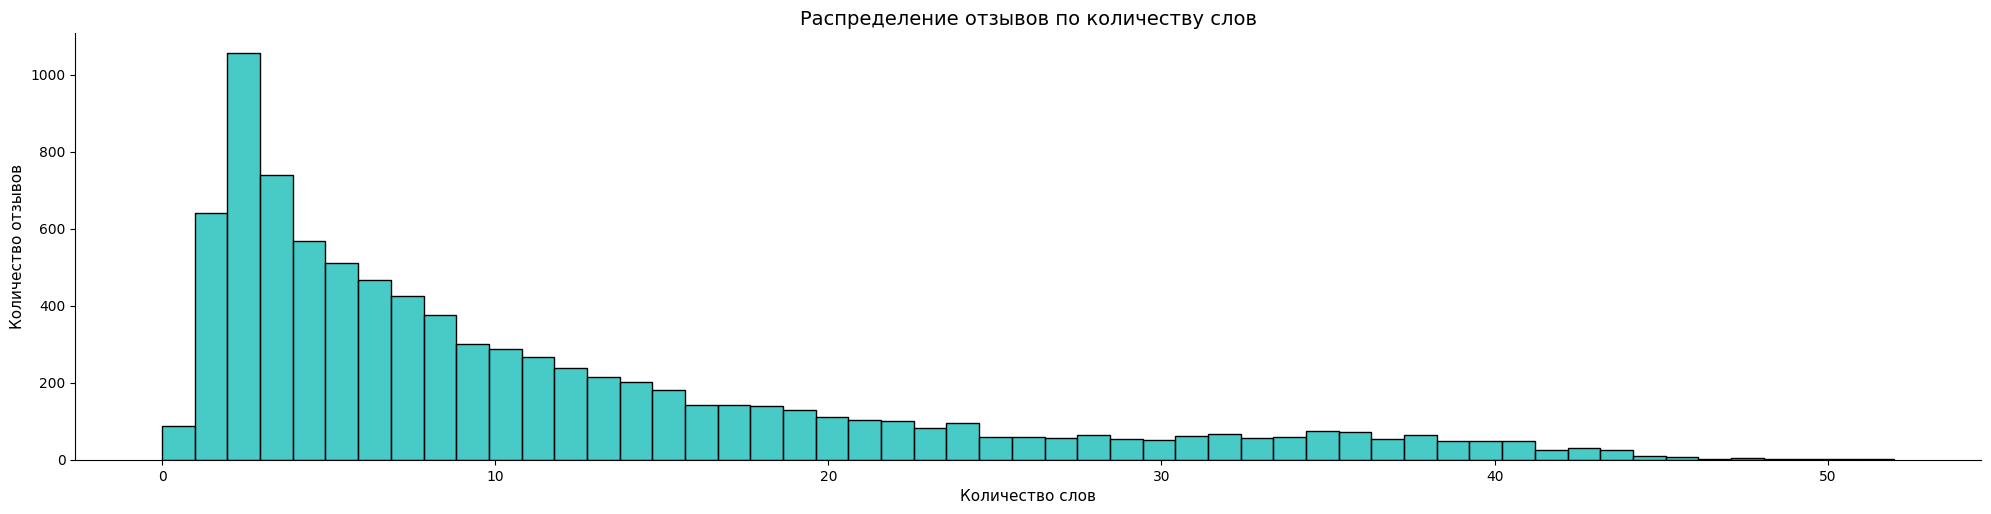

In [ ]:
tmp = df['cleaned_text'].apply(count_words)
g = sns.displot(
    data=tmp,
    color = color,
    legend=True,
    aspect=4,
    kind="hist",
    bins=53
)
plt.xlabel('Количество слов',size=11)
plt.ylabel('Количество отзывов', size=11)
plt.title('Распределение отзывов по количеству слов', size=14);

Большинство отзывов не длиннее 10 слов. Наиболее распространены фразы из 2-3 слов.<br> Также встречаются сообщения состоящие из одних смайликов.


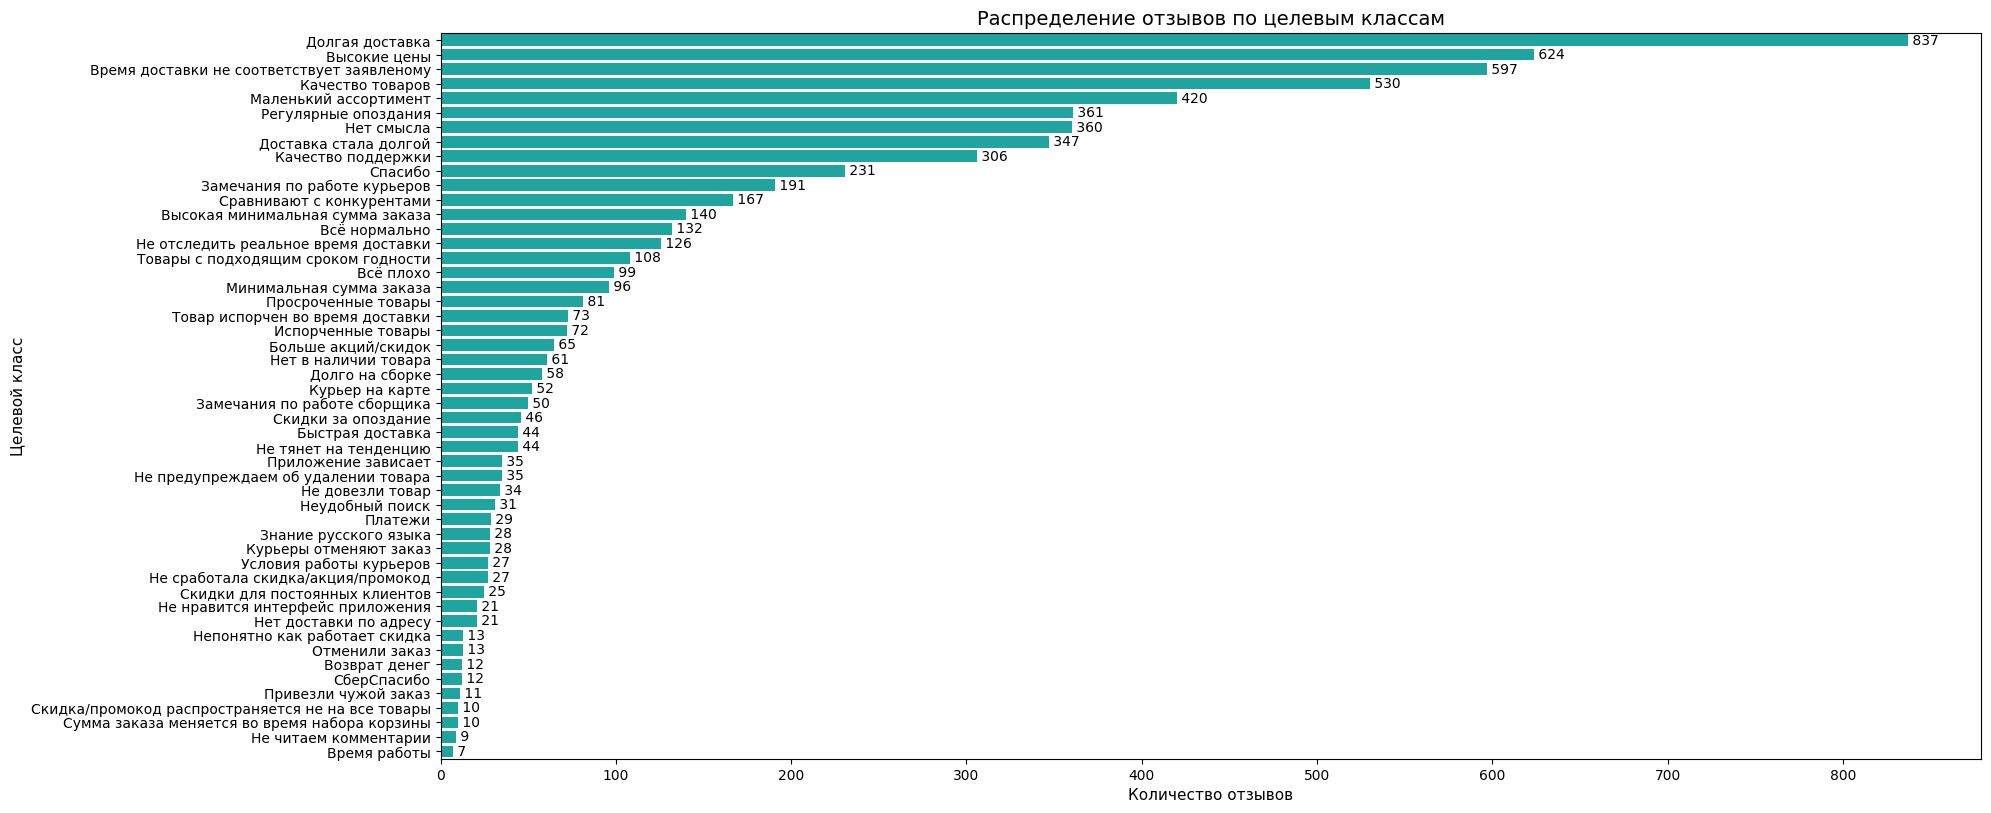

In [ ]:
tmp = pd.DataFrame({
    'target' : target_names,
    'count' : df[target_cols].sum()
}).sort_values(by='count', ascending=False)

fig, ax = plt.subplots(figsize=(20, 8))
g = sns.barplot(data=tmp, y='target', x='count', color=color)

ax.bar_label(g.containers[0], fmt=' %1.f', label_type='edge')
plt.tight_layout()
plt.xlabel('Количество отзывов', size=11)
plt.ylabel('Целевой класс', size=11)
plt.title('Распределение отзывов по целевым классам', size=14);

In [ ]:
df.query('unlabeled != 1').shape

(4654, 65)

Анализируя график, можно заметить, что практически каждый шестой отзыв указывает на проблему с длительностью доставки. <br>
В сумме же, из 4654 размеченных отзывов, в 2142  упоминают тот или иной аспект доставки.<br>
Для компании, специализирующейся на экспресс-доставке, эти данные подчеркивают ключевую роль доставки в общем восприятии услуг компании.<br>
Помимо этого, у клиентов вызывают вопросы стоимость и качество товаров.


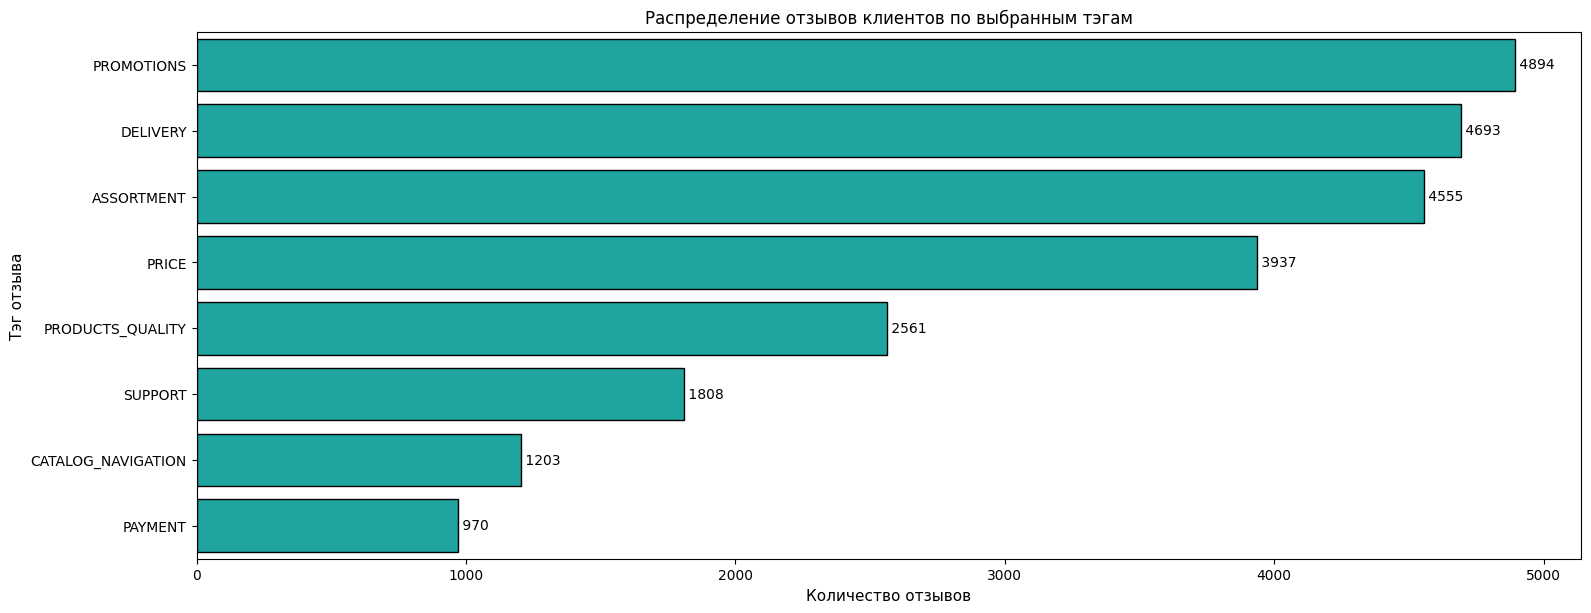

In [ ]:
tags_columns = ['ASSORTMENT', 'CATALOG_NAVIGATION', 'DELIVERY', 'PAYMENT',
                    'PRICE', 'PRODUCTS_QUALITY', 'PROMOTIONS', 'SUPPORT']
tmp = pd.DataFrame(
    df[tags_columns].sum(),
    columns=['count']
).reset_index().sort_values(by='count', ascending=False)

fig, ax = plt.subplots(figsize=(16, 6))
g = sns.barplot(data=tmp, y='index', x='count', color=color, edgecolor='black', ax=ax)

ax.bar_label(g.containers[0], fmt=' %1.f', label_type='edge')

plt.tight_layout()
plt.xlabel('Количество отзывов', size=11)
plt.ylabel('Тэг отзыва',  size=11)
plt.title('Распределение отзывов клиентов по выбранным тэгам');

На основании распределения выбираемых пользователями тэгов на вопрос об улучшении сервисов, можно сделать вывод, что наиболее проблемными для потребителя представляются следующие категории: промо, доставка и ассортимент.<br>
В то же время, наименьшее число отзывов связано с процессами оплаты и навигации по каталогу, что может свидетельствовать о их приемлемом уровне или о меньшей важности этих сервисов для клиентов на фоне остальных.

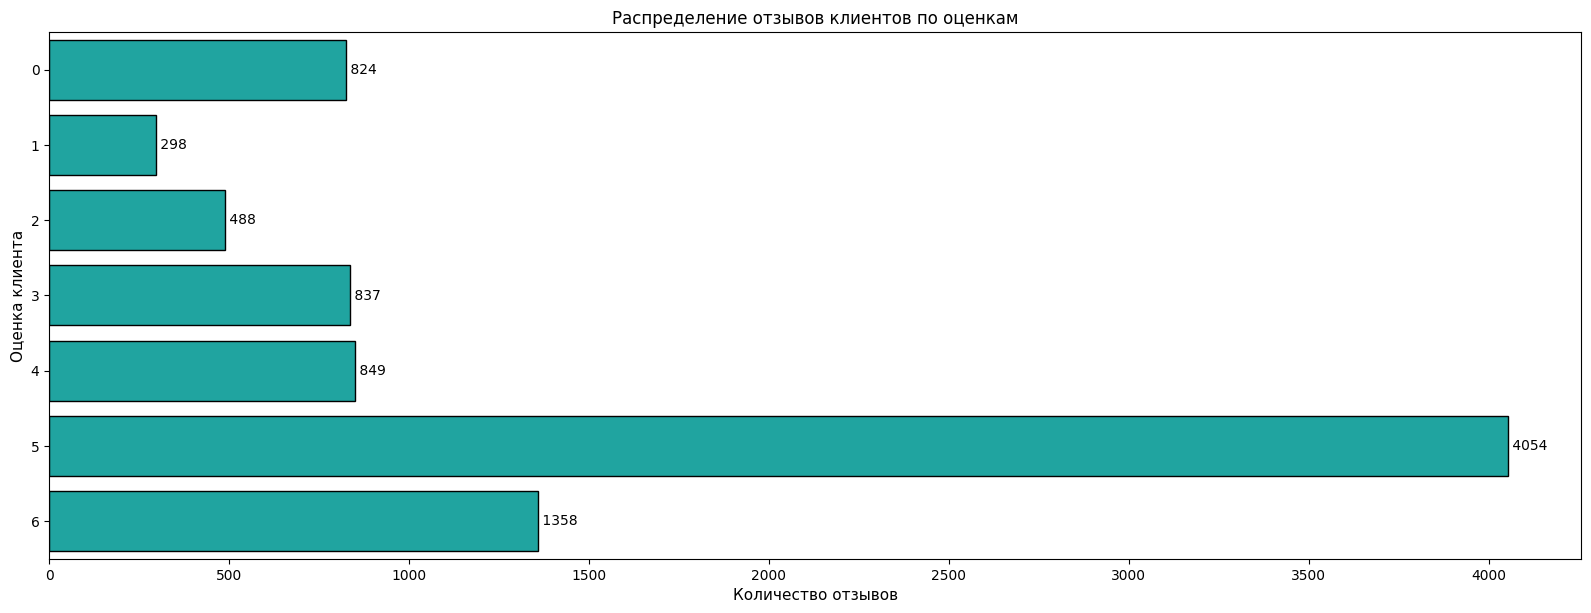

In [ ]:
tmp = df.groupby('assessment', as_index=False).index.count()
fig, ax = plt.subplots(figsize=(16, 6))
g = sns.barplot(data=tmp, y='assessment', x='index', color=color, edgecolor='black', ax=ax, orient='h')

ax.bar_label(g.containers[0], fmt=' %1.f', label_type='edge')

plt.tight_layout()
plt.xlabel('Количество отзывов', size=11)
plt.ylabel('Оценка клиента',  size=11)
plt.title('Распределение отзывов клиентов по оценкам');

Почти половина всех отзывов имеют оценку 5. Низшие оценки имеют сравнительно небольшую долю.<br>
Эти данные могут свидетельствовать о том, что большинство клиентов остаются довольны услугами компании.

In [ ]:
df.query('assessment != 5')['assessment'].corr(df['tag_count'])

-0.057435370284217406

Корреляция между оценкой и количеством классов к которым относится отзыв нулевая.

In [ ]:
def plot_cloud(wordcloud):
   # %matplotlib inline
    plt.figure(figsize=(18, 8))
    plt.imshow(wordcloud)
    plt.axis("off")

In [ ]:
def create_wordcloud(text):
    wordcloud = WordCloud(
        background_color='black',
        width = 2000,
        height = 1000,
        max_words=120,
        contour_width=3,
        contour_color='steelblue',
        random_state=1,
        colormap='Spectral',
        collocations=False,
        stopwords=russian_stopwords
    ).generate(text)

    plot_cloud(wordcloud)

In [ ]:
text = ''.join(df['lemmatized_text'])

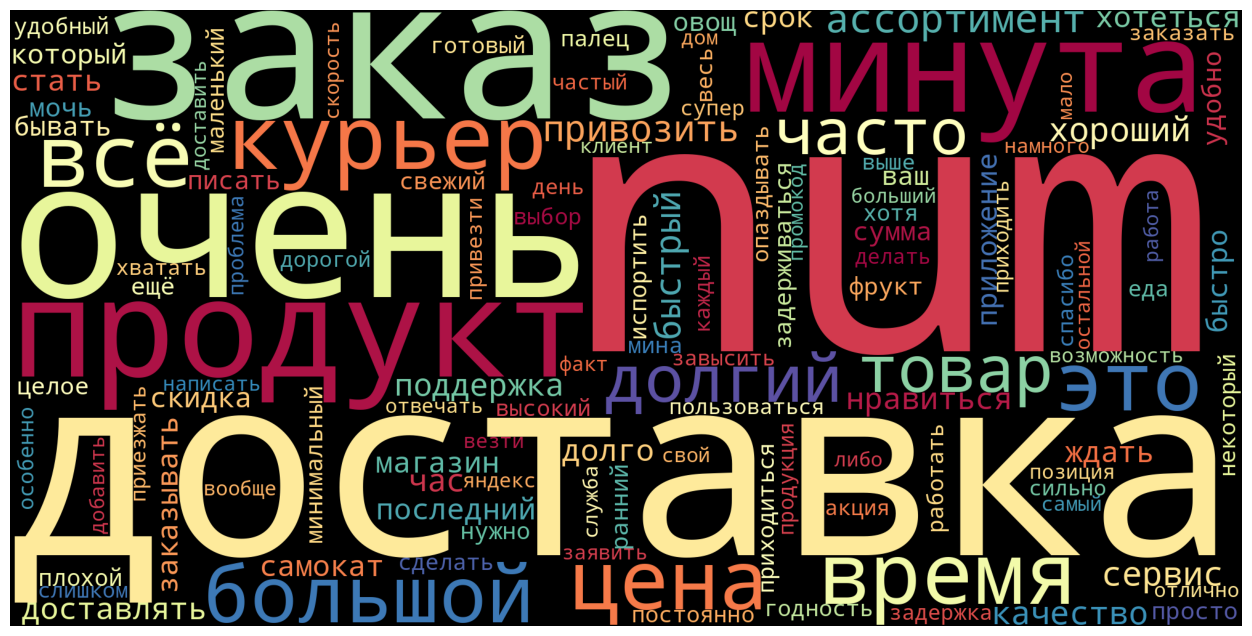

In [ ]:
create_wordcloud(text)

Облако слов позволяет получить общее представление о самых распространненых словах в отзывах, но нам интереснее изучить самые частые слова в зависимости от класса. <br>
Галерея из 50 подобных графиков будет трудна для восприятия и анализа поэтому применим иной метод.

In [ ]:
data_for_heatmap = []  # Сюда будем собирать данные
labels_for_heatmap = []  # Сюда будем собирать слова для отображения в ячейках
vectorizer = CountVectorizer(stop_words=russian_stopwords + ['num'], max_features=10, binary=True)

# Перебираем каждый столбец класса
for i, target_col in enumerate(target_cols):

    # Выбираем тексты, принадлежащие классу
    target_idx = df[target_col] == 1
    class_texts = df.loc[target_idx, 'cleaned_text']

    # Построение матрицы частот слов для класса
    count_matrix = vectorizer.fit_transform(class_texts)
    feature_names = vectorizer.get_feature_names_out()
    words_sum = np.array(count_matrix.sum(axis=0)).flatten()

    #Объеденим количества слов и слова в кортеж для совместной сортировки по убыванию частоты слов
    combined = sorted(zip(words_sum, feature_names), reverse=True, key=lambda x: x[0])

    words_sum, feature_names = zip(*combined)

    # Нормализация частот слов
    normalized_counts = words_sum / np.sum(words_sum)

    data_for_heatmap.append(normalized_counts)
    labels_for_heatmap.append(feature_names)

tmp = pd.DataFrame(data_for_heatmap, index=target_names)

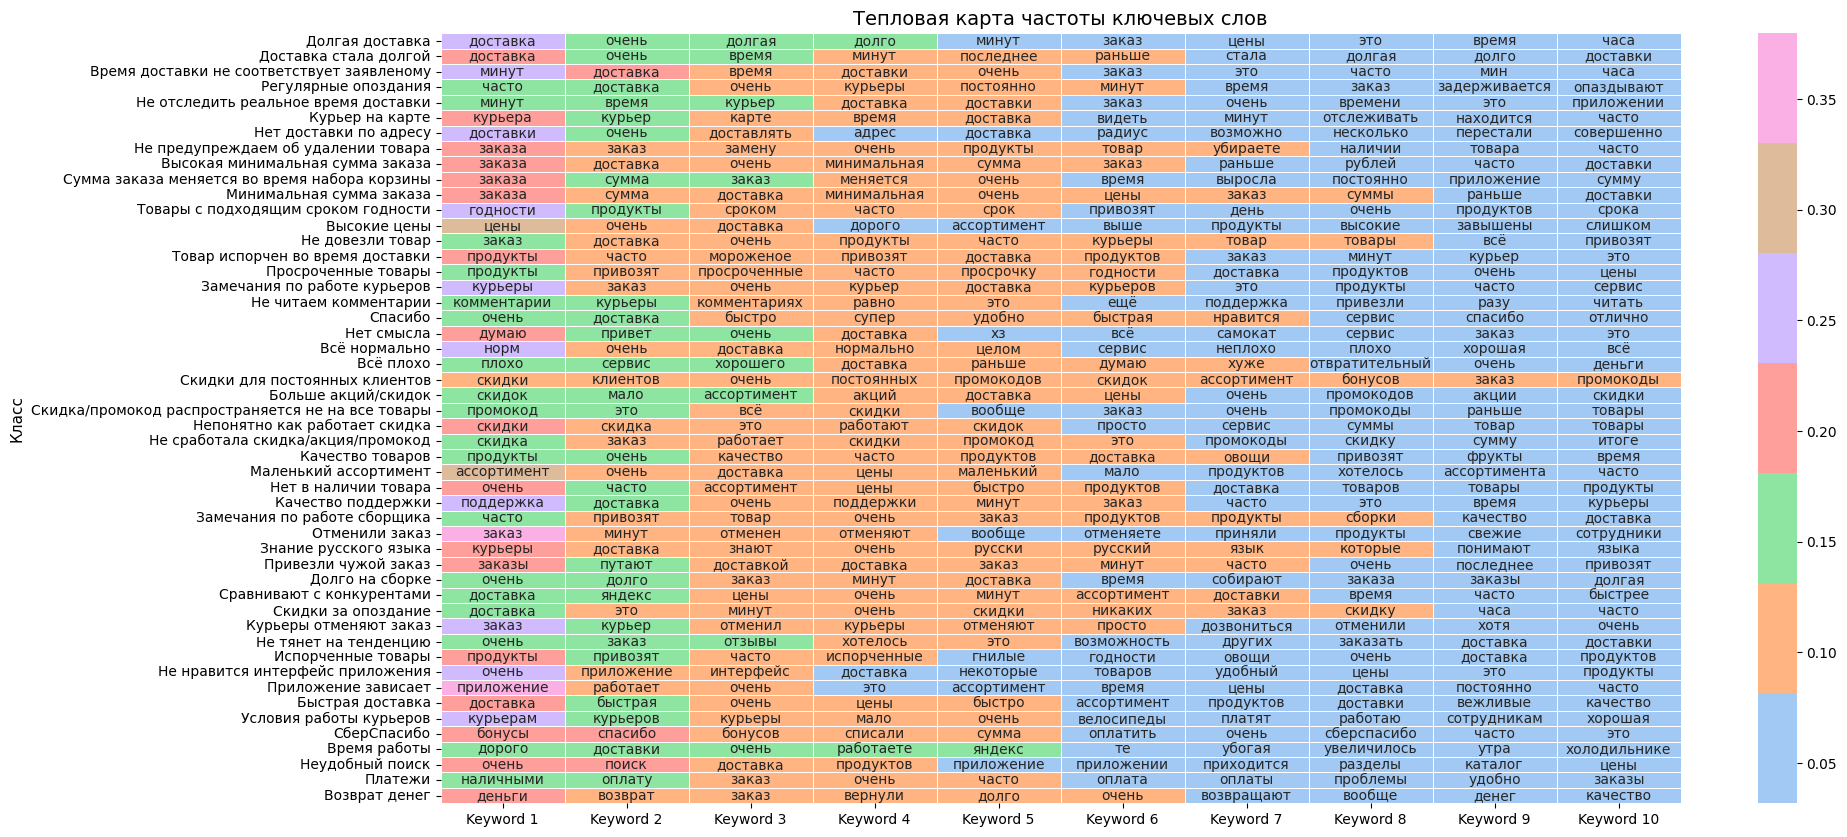

In [ ]:
ccm = sns.color_palette("pastel", 7)
plt.figure(figsize=(20, 10))
sns.heatmap(tmp, annot=labels_for_heatmap, fmt='', cmap=ccm, linewidths=.5,)
plt.xticks(np.arange(0.5, len(tmp.columns)), [f'Keyword {i+1}' for i in range(len(tmp.columns))])
plt.ylabel('Класс', size=11)
plt.title('Тепловая карта частоты ключевых слов', size=14)
plt.show()

**На этапе предобработки данных:**
1. Мы выяснили, что почти половина строк в обучающем и тестовом датафреймах неразмечены, неразмеченные отзывы и отзывы с оценкой 5 совпадают на 99%. Так как такая же ситуация в тестовом наборе, мы не можем отбросить неразмеченные строки, а одним из ключевых признаков для модели будет бинарный признак, оценен ли отзыв 5 или нет.
2. Мы преобразовали столбец с тэгами методом `get_dummies`. Передача получившихся признаков модели улучшила ее предсказательную способность.
3. Произвели предобработку и лемматизацию текста, что привело к незначительному росту метрики

**Анализ данных выявил, что:**
1. Длина большинства отзывов не превышает 10 слов. А наиболее частая длина - 2-3 слова.
2. Почти половина отзывов относится к одному из классов связанных с доставкой.
3. Наиболее остро для клиентов стоят вопросы улучшения категорий промо, доставка и ассортимент.



---

## Augmentation

Произведем аугментацию текста методом `Back Translation`.<br>
В этом нам помогут библиотека для аугментации `NLPaug` и модель для перевода текстов `Helsinki-NLP`

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
aug = naw.BackTranslationAug(
    from_model_name='Helsinki-NLP/opus-mt-ru-en',
    to_model_name='Helsinki-NLP/opus-mt-en-ru',
    device=device
);

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

In [ ]:
def get_aug(df):
    """
    Функция для аугментации текстовых данных в DataFrame.

    Параметры:
    - df: DataFrame, содержащий столбцы 'assessment' и 'text'.

    Возвращает:
    - DataFrame, содержащий оригинальные строки и аугментированные строки для текстов,
      где оценка (assessment) не равна 5 и текст не пустой.

    Примечание: перед использованием этой функции необходимо инициализировать объект aug,
    который отвечает за аугментацию текста.
    """
    # Отбор строк для аугментации
    to_aug = df.query('assessment != 5 and text != ""')
    new_rows = []

    # Аугментация текста
    for i, row in tqdm(to_aug.iterrows(), total=len(to_aug)):
        new_row = row.copy()
        original_text = row['text']
        augmented_text = aug.augment(original_text)
        new_row['text'] = augmented_text[0]  # предполагается, что aug.augment возвращает список
        new_rows.append(new_row)

    # Создание DataFrame из новых строк
    new_texts_df = pd.DataFrame(new_rows)

    # Объединение оригинального и аугментированного DataFrame
    full_df = pd.concat([df, new_texts_df], ignore_index=True)

    return full_df

In [ ]:
#df = get_aug(df)

In [ ]:
df = pd.read_csv('/kaggle/input/augmented-df/augmented_df.csv')

In [ ]:
df['cleaned_text'] = df['cleaned_text'].fillna('')
df['lemmatized_text'] = df['lemmatized_text'].fillna('')

In [ ]:
cv(df.query('assessment != 5'), features2drop=['index',  'tag_count', 'text', 'cleaned_text', 'prepared_text'], pipeline=get_pipe(text_col='lemmatized_text'))

KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


0.316

---

## Models

### Embeddings

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")
model.to(device)
model.eval();

tokenizer_config.json:   0%|          | 0.00/323 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # Получаем эмбеддинги токенов
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
texts = df['cleaned_text'].tolist()

In [ ]:
encoded_inputs = tokenizer(texts, padding=True, truncation=True, max_length=64, return_tensors='pt')

In [ ]:
dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
loader = DataLoader(dataset, batch_size=32)

In [ ]:
embeddings = []
with torch.no_grad():  # Отключаем вычисление градиентов
    for batch in tqdm(loader, desc="Computing embeddings"):
        input_ids, attention_mask = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        model_output = model(input_ids, attention_mask=attention_mask)
        batch_embeddings = mean_pooling(model_output, attention_mask)

        embeddings.append(batch_embeddings.cpu().numpy())

embeddings_array = np.vstack(embeddings)

Computing embeddings:   0%|          | 0/418 [00:00<?, ?it/s]

In [ ]:
embs = pd.DataFrame(embeddings_array, columns=[f'emb_{i}' for i in range(1024)])
df_with_embs = pd.concat([df, embs], axis=1)

---

### Models comparison

In [ ]:
cbc = CatBoostClassifier(
    loss_function='MultiLogloss',
    task_type='GPU' if torch.cuda.is_available() else 'CPU',
    random_seed=1,
    verbose=0
)

xgb = XGBClassifier(
    device = 'cuda',
    random_state=1
)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=1,
    n_jobs=-1
)

svc = SVC(
    kernel='linear',
    C=1.0,
    random_state=1
)

In [ ]:
models = {'Catboost' : cbc,
          'XGB' : xgb,
          'Random Forest' : MultiOutputClassifier(rf),
          'Logistic Regression' : lr,
          'SVC' : MultiOutputClassifier(svc)
         }

In [ ]:
labeled_df = df.query('assessment != 5')
labeled_embs = df_with_embs.query('assessment != 5')

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=5000, binary=True)

In [ ]:
features2drop = ['index', 'tag_count', 'text', 'cleaned_text', 'unlabeled']
features2drop_embs = features2drop + ['lemmatized_text']

In [ ]:
models_results = pd.DataFrame(index=list(models.keys()), columns = ['tfidf', 'count vectorizer', 'embeddings'])

In [ ]:
models_results = pd.DataFrame(index=list(models.keys()), columns = ['tfidf', 'count vectorizer', 'embeddings'])

for name, model in models.items():

    tfidf_pipe = get_pipe(model=model, text_col='lemmatized_text')
    count_vec_pipe = get_pipe(model=model,method = vectorizer, text_col='lemmatized_text')


    acc_1 = cv(df, features2drop=features2drop, pipeline=tfidf_pipe)

    acc_2 = cv(df, features2drop=features2drop, pipeline=count_vec_pipe)

    acc_3 = cv(df_with_embs, features2drop=features2drop_embs, pipeline=model)

    models_results.loc[name] = [acc_1, acc_2, acc_3]

KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Accuracy:


KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


KFold Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy:


In [ ]:
models_results

,tfidf,count vectorizer,embeddings
Catboost,0.556,0.497,0.519
XGB,0.597,0.609,0.543
Random Forest,0.472,0.512,0.419
Logistic Regression,0.437,0.467,0.468
SVC,0.439,0.48,0.43


Анализ эффективности различных алгоритмов машинного обучения с использованием трех разных методов векторизации текста (TF-IDF, Count Vectorizer и Embeddings) позволяет сделать следующие выводы:

- XGBoost показал наилучшие результаты, особенно при использовании Count Vectorizer (0.609). Также этот алгоритм показал хорошие результаты с TF-IDF (0.597), что делает его предпочтительным выбором для задач классификации текста в данном исследовании.
- CatBoost также показал приемлемые результаты с TF-IDF (0.556), но его производительность ухудшилась с использованием других методов векторизации.
- Random Forest и Support Vector Classifier (SVC) работают лучше с Count Vectorizer, чем с другими методами векторизации, однако их показатели Accuracy остаются относительно низкими по сравнению с XGBoost.
- Логистическая регрессия показала худшие результаты в целом, но сравнимую эффективность для Embeddings и Count Vectorizer.

Важно отметить, что результаты получены с помощью валидации на данных после аугментации. Так как обратный перевод мы применяли только к размеченным строкам, баланс изменился в сторону размеченных. На тестовом наборе, где половина данных остается неразмеченной результаты скорее всего будут выше.

---

## Fine-tunig предобученной модели

Теперь попробуем адаптировать LLM для нашей задачи

Загрузим предобученные модель и токенайзер

In [ ]:
model_name = 'ai-forever/ruT5-base'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=50,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification"
).to(device);

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruT5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class TextClassifierDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

In [ ]:
def multi_label_metrics(predictions, labels, threshold=0.5):

    # Применяем сигмоидную функцию для преобразования предсказаний в вероятности от 0 до 1.
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # Инициализируем массив нулями для бинаризированных предсказаний
    y_pred = np.zeros(probs.shape)
    # Записываем единицы в те места, где вероятность предсказаний превышает установленный порог
    y_pred[np.where(probs >= threshold)] = 1

    # Сохраняем истинные метки для дальнейшего использования в метриках
    y_true = labels
    # Вычисляем F1-меру с учетом всех классов (micro-average)
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    # Вычисляем площадь под ROC-кривой для каждого класса и усредняем (micro-average)
    roc_auc = roc_auc_score(y_true, probs, average='micro', multi_class='ovo')
    # Вычисляем точность как долю верно определенных классов
    accuracy = accuracy_score(y_true, y_pred)
    # Формируем словарь с рассчитанными метриками
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

In [ ]:
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [ ]:
def add_tags_and_assessment(row):
    """
    Функция для формирования строки с оценкой, тегами и текстом отзыва.

    Параметры:
    - row: строка DataFrame, содержащая данные об отзыве.

    Возвращает:
    - Строку с информацией об оценке, тегах (если таковые имеются) и тексте отзыва.
      Если отзыв не размечен (оценка 5) или текст отсутствует, возвращает соответствующий текст.
    """
    tags_columns = ['ASSORTMENT', 'CATALOG_NAVIGATION', 'DELIVERY', 'PAYMENT',
                    'PRICE', 'PRODUCTS_QUALITY', 'PROMOTIONS', 'SUPPORT']

    tags = [tag for tag in tags_columns if row[tag] == 1]

    if row['assessment'] == 5:
        return 'неразмеченный отзыв'
    elif row['text'] == '':
        return 'нет смысла'
    else:
        return (f"оценка {row['assessment']} | {' | '.join(tags)} | {row['text']}").lower()

In [ ]:
def clean_text_light(text):

    #Уберем лишние пробелы
    text = text.strip()

    #Приведем текст к нижнему регистру
    text = text.lower()

    return text

In [ ]:
df['text'] = df['text'].apply(clean_text_light)

In [ ]:
df['full_text'] = df.apply(add_tags_and_assessment, axis=1)

Создадим наборы данных для обучения и валидации

In [ ]:
texts = df['full_text'].values.tolist()
labels_list = df[target_cols].astype('float').values.tolist()

In [ ]:
train_texts, eval_texts, train_labels, eval_labels = train_test_split(texts, labels_list, test_size=0.1, random_state=1)

In [ ]:
train_encodings = tokenizer(train_texts, padding= "max_length" , truncation= True , max_length=128)
eval_encodings = tokenizer(eval_texts, padding= "max_length" , truncation= True , max_length= 128)

In [ ]:
train_dataset = TextClassifierDataset(train_encodings, train_labels)
eval_dataset = TextClassifierDataset(eval_encodings, eval_labels)

Установим аргументы обучения

In [ ]:
training_arguments = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=150,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_strategy='epoch',
    save_total_limit=1,
    #warmup_steps=500,
    learning_rate=3e-5,
    metric_for_best_model='accuracy'
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics = compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]
)

Приступим к обучению

In [ ]:
#trainer.train()

Чтобы повторно не обучать модель, мы сохранили ее и лог обучения

In [ ]:
with open("/kaggle/input/trainer-state/trainer_state.json", "r") as file:
    trainer_state = json.load(file)

log_history = trainer_state.get("log_history")
log_df = pd.DataFrame(log_history)

In [ ]:
log_df['epoch'] = log_df['epoch'].astype('int')

In [ ]:
filtered_df = log_df.dropna(subset=['eval_loss', 'eval_accuracy'])

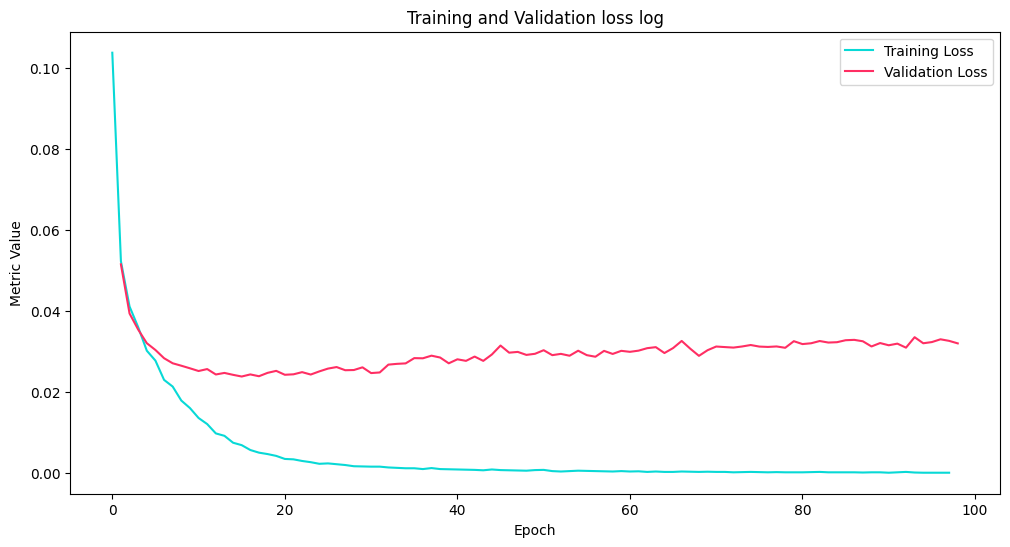

In [ ]:
tmp = log_df.groupby('epoch')[['loss', 'eval_loss']].mean()
plt.figure(figsize=(12, 6))
plt.plot(tmp.index, tmp['loss'], label='Training Loss', color='#08d9d6')
plt.plot(tmp.index, tmp['eval_loss'], label='Validation Loss', color='#ff2e63')
plt.title('Training and Validation loss log')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

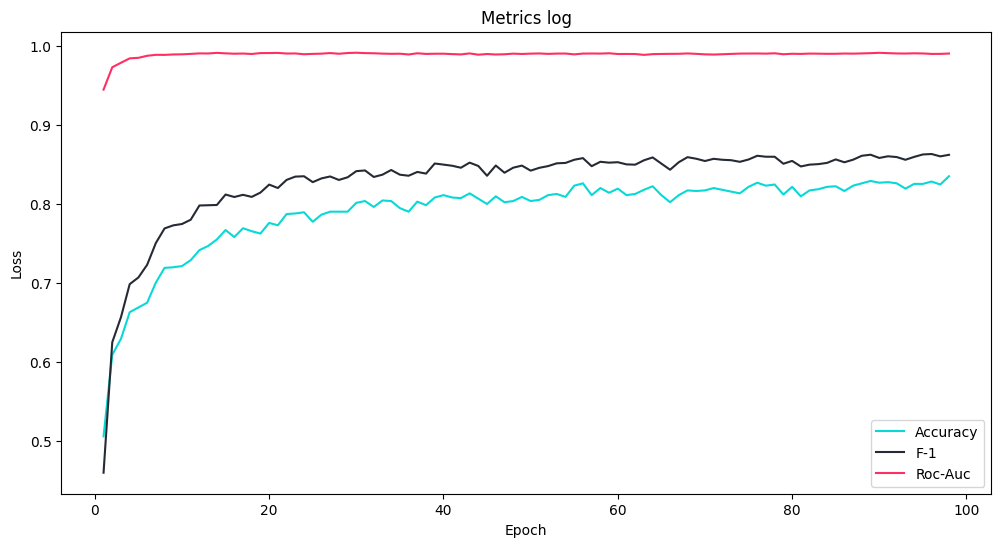

In [ ]:
plt.figure(figsize=(12, 6))
tmp = log_df.groupby('epoch')[['eval_accuracy', 'eval_f1', 'eval_roc_auc']].mean()
plt.plot(tmp.index, tmp['eval_accuracy'], label='Accuracy', color='#08d9d6')
plt.plot(tmp.index, tmp['eval_f1'], label='F-1', color='#252a34')
plt.plot(tmp.index, tmp['eval_roc_auc'], label='Roc-Auc', color='#ff2e63')

plt.title('Metrics log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Загрузим предобученную модель после файнтюнинга
config = AutoConfig.from_pretrained('/kaggle/input/t5-fine-tuned-final/config.json')
model = AutoModelForSequenceClassification.from_pretrained('/kaggle/input/t5-fine-tuned-final', config=config).to(device)
model.eval;

---

## Получение предсказаний для теста

In [ ]:
def prepare(data):
    data['assessment'] = data['assessment'].fillna(5).astype('int')

    data = encode_tags(data)

    data['text'] = data['text'].fillna('').apply(clean_text_light).fillna('')

    data['full_text'] = data.apply(add_tags_and_assessment, axis=1)

    return data

In [ ]:
prepared_test = prepare(test_df)
test_texts = prepared_test['full_text'].tolist()

In [ ]:
all_predictions = []

for text in test_texts:
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    inputs = inputs.to(device)

    with torch.no_grad():  # Отключаем подсчет градиентов
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.sigmoid(logits)  # Преобразуем логиты в вероятности
    predictions = (probabilities > 0.5).long()  # Бинаризация вероятностей

    all_predictions.append(predictions.cpu().numpy())

In [ ]:
pred_test = np.vstack(all_predictions)
res = pd.DataFrame(np.hstack([test_df["index"].values.reshape(-1, 1), pred_test]),
                   columns=["index"] + [f"trend_id_res{i}" for i in range(50)])

In [ ]:
res.to_csv('submission.csv', index=False)

Public score: 0.75107

---

## Финальный вывод

В рамках проекта была поставлена задача разработки модели машинного обучения для мультилейбловой классификации отзывов клиентов, т.е. ситуации, когда один отзыв может относиться к нескольким категориям одновременно. Основной метрикой для оценки эффективности модели была выбрана Accuracy — доля полных совпадений предсказанных категорий с истинными для всего набора данных.

Работа над проектом включала несколько ключевых этапов: загрузку и первичный обзор данных, (EDA), валидацию моделей и методов представления текста, аугментацию данных и файнтюнинг предобученной LLM. Лучшие результаты показал файнтюнинг  модели `ai-forever/ruT5-base`.

В итоге, после загрузки предсказаний на платформу Kaggle, был получен результат с Accuracy 0.75. Однако важно отметить, что почти половина данных в тестовом наборе была не размечена, что значительно влияет на оценку реальной эффективности модели. При учете только размеченных данных реальная Accuracy модели оценивается в около 0.5, что указывает на то, что модель корректно классифицирует примерно половину отзывов.

Результаты проекта подчеркивают сложность задачи мультилейбловой классификации текстов и важность комплексного подхода к предобработке данных, выбору и настройке моделей. Полученный результат может служить основой для дальнейшего улучшения модели, включая более глубокий анализ ошибок, эксперименты с различными стратегиями обработки текста, применение более продвинутых техник аугментации(lambada) и последующей фильтрации, и иные методы адаптации предобученной LLM, более подходящие для условий небольшого набора данных - LoRA и Promt-tuning. Также, очевидно, необходимо производить валидацию на полностью размеченном датасете.